## Create cost surfaces 
This notebook creates a simple set of cost distance surfaces, one for each biogas source. 

In [1]:
#Import packages
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, box
import osmnx as ox
from pyproj import CRS
import rasterio
from rasterio import features, plot
from matplotlib import pyplot as plt

### Read in the cost surface raster

In [2]:
#Load the cost surface raster
cost_surface_dataset = rasterio.open('../data/costsurface500m.img')
#Extract the first (and only) band
cost_surface = cost_surface_dataset.read(1)
#Extract the coordinate reference system
cost_crs = cost_surface_dataset.crs

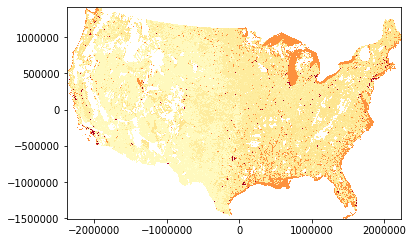

In [3]:
#Display 
plot.show(cost_surface_dataset,cmap='YlOrRd')

### Read in the biogas location data
These data are stored as the "Swine" sheet in the "NC_Biogas_Potential.xlsx" file. These records include the lat/long coordinates of each swine lagoon as well as its biogas potential in ($f^3/yr$). 
* First, calculations must be made to convert the potential into cost to pipe ($\$/{mi-MMBtu@15yr}$).
* Then the data must be converted to a geodataframe and transformed to match the coordinate reference system of the cost surface.

In [4]:
#Read in biogas sources (example: Duplin Co)
dfBG =  pd.read_excel('../data/NC_Biogas_Potential.xlsx',sheet_name='Swine')
#Remove the total row
dfBG = dfBG.loc[dfBG['Facility Name']!='TOTAL']

#### Create a dataframe of per-yead yield by farm type

In [5]:
#Create a dataframe of per-yead yield by farm type
biogas_methane_content = 0.60 #B3 
biogas_CO2_content = 0.40     #B2
MMBtu_per_tsf = 1.037         #C6


#Create dataframe of type and biogas yield
df_farm_type_yield = pd.DataFrame(data = [['Swine - Feeder to Finish', 2336],
                                          ['Swine - Wean to Feeder', 420], 
                                          ['Swine - Wean to Finish', 2068], 
                                          ['Swine - Farrow to Wean', 1183],
                                          ['Swine - Farrow to Finish',1603]],
                                  columns = ['farm type','biogas (scf/y)'])

#Compute methane yield from biogas and constants
df_farm_type_yield['methane (MMBtu/year)'] = (df_farm_type_yield['biogas (scf/y)'] * 
                                              biogas_methane_content *
                                              MMBtu_per_tsf / 1000)

#Set the index to the farm type
df_farm_type_yield.set_index('farm type',inplace=True)

#Reveal the table
df_farm_type_yield

,biogas (scf/y),methane (MMBtu/year)
farm type,,
Swine - Feeder to Finish,2336,1.453459
Swine - Wean to Feeder,420,0.261324
Swine - Wean to Finish,2068,1.286710
Swine - Farrow to Wean,1183,0.736063
Swine - Farrow to Finish,1603,0.997387


#### Conversions
Construct a function that computes hourly methane yield for each lagoon based on its farm type and head count

In [6]:
#Calculate cost per mile-MMBtu over 15 years for a source, given its farm type and head_count
def compute_cost(head_count, farm_type):
    #Constants
    hours_per_year = 365 * 24                       #C6
    low_pressure_diameter_power = 0.394185319       #C62
    low_pressure_diameter_coefficient = 0.050593064 #C63
    cost_curve_slope = -7.4295332                   #G21
    cost_curve_intercept = 69.5084756               #H21
    low_pressure_cost_power = 0.485441535           #G62
    low_pressure_cost_coefficient = 10829.06613     #G63
    
    #Check that farm yield data exist, return NoData if not
    if farm_type not in df_farm_type_yield.index or head_count == 0:
        return np.nan

    #Compute biogas yield feed flow (scf/h) from farm type and head count
    lagoon_biogas_feed_flow = df_farm_type_yield.loc[farm_type,'biogas (scf/y)'] * head_count / hours_per_year 

    #Compute hourly methane yield (MMBtu/yr) from farm type and head count
    lagoon_methane_yield_yr = df_farm_type_yield.loc[farm_type,'methane (MMBtu/year)'] * head_count 

    #Compute annual methane yield (scf/h) from hourly yield
    lagoon_methane_yield_hr = lagoon_methane_yield_yr / hours_per_year * 1000 * MMBtu_per_tsf

    #Compute pipe diameter (in.) from hourly methane yield & coefficients
    pipe_diameter = low_pressure_diameter_coefficient * (lagoon_methane_yield_hr**low_pressure_diameter_power)

    #Compute production cost ($/MMBtu) from feed rate & coefficients
    pipe_cost = cost_curve_slope * np.log(lagoon_biogas_feed_flow) + cost_curve_intercept

    #Compute total production cost
    cost_per_year = lagoon_methane_yield_yr * pipe_cost

    #Compute cost per mile (low pressure)
    cost_per_mile = low_pressure_cost_coefficient * pipe_diameter**low_pressure_cost_power

    #Compute 15-year cost per MMBtu
    cost_per_MMBtu_15 = cost_per_mile / (lagoon_methane_yield_yr * 15)
    
    #Return the total cost
    return cost_per_MMBtu_15

In [7]:
#Apply the function
dfBG['Pipe Cost ($/mi-MMBtu@15y)'] = dfBG.apply(lambda x: compute_cost(x['Allowable Count'],x['Regulated Activity']),axis=1)

In [8]:
#Drop "missing" sites
dfBG = dfBG.dropna(subset=['Pipe Cost ($/mi-MMBtu@15y)'])

In [9]:
#Sort values in ascending order by biogas potential
dfBG = dfBG.sort_values(by='Biogas Potential (f^3 / year)',
                        ascending=False).reset_index()

#### Convert dataframe to a geodataframe

In [10]:
#Convert to geodataframe from lat/lng coordinates
geom = [Point(xy) for xy in zip(dfBG['Longitude'],dfBG['Latitude'])]
gdfBG = gpd.GeoDataFrame(dfBG,geometry=geom,crs=4326)

In [ ]:
#Subset points falling in Duplin County
#duplin_co = ox.gdf_from_place('Duplin County, NC').unary_union
#gdfBG = gdfBG.loc[gdfBG.geometry.within(duplin_co)]

In [12]:
#Project to same crs as raster
gdfBG = gdfBG.to_crs(cost_crs)

In [14]:
#Subset records intersecting cost surface
bbox = box(*cost_surface_dataset.bounds)
gdfBG = gdfBG.loc[gdfBG.geometry.within(bbox)]

In [16]:
#Get x and y offsets for each point
#gdfBG['idx'] = gdfBG['geometry'].apply(lambda g: cost_surface_dataset.index(g.x,g.y))
gdfBG['xOffset'] = gdfBG['geometry'].apply(lambda g: cost_surface_dataset.index(g.x,g.y)[1])
gdfBG['yOffset'] = gdfBG['geometry'].apply(lambda g: cost_surface_dataset.index(g.x,g.y)[0])

In [23]:
gdfBG.head()

,index,Facility Name,Address,City,County Name,Zip,Latitude,Longitude,Regulated Activity,Allowable Count,Total Waste (tons / year),Biogas Potential (m^3 / year),Biogas Potential (f^3 / year),Pipe Cost ($/mi-MMBtu@15y),geometry,idx,xOffset,yOffset
0,179,Mr. Holmes Sites #1 - #14 #1 7 #18 Blueberry S...,2313 Mr Holmes Farm Rd,Garland,Bladen,28441.0,34.819191,-78.544711,Swine - Feeder to Finish,64680,248472.480342,6.957229e+06,2.456923e+08,0.010729,POINT (1582930.135 -312033.532),"(3430, 7853)",7853,3430
1,2106,Somerset Farm,Sr 1139 1855-A N Line Rd,Roper,Washington,27970.0,35.888900,-76.535800,Swine - Feeder to Finish,59000,226652.386212,6.346267e+06,2.241163e+08,0.011556,POINT (1737344.043 -159200.306),"(3127, 8159)",8159,3127
2,2112,White Oaks Farm Inc,604 Benton Pond Rd,Fremont,Wayne,27830.0,35.516100,-77.923100,Swine - Wean to Finish,60000,192948.551040,5.402559e+06,1.907896e+08,0.012581,POINT (1623349.684 -225251.540),"(3258, 7933)",7933,3258
3,345,Magnolia III DM Section 4 Sites 1-4 Section 3 ...,1114 Beasley Mill Rd,Warsaw,Duplin,28398.0,34.887500,-78.131400,Swine - Feeder to Finish,48520,186392.775915,5.218998e+06,1.843072e+08,0.013536,POINT (1618460.904 -297343.380),"(3401, 7924)",7924,3401
4,328,Magnolia III DM Section 4 Sites 1-4 Section 3 ...,1114 Beasley Mill Rd,Warsaw,Duplin,28398.0,34.887500,-78.131400,Swine - Feeder to Finish,48520,186392.775915,5.218998e+06,1.843072e+08,0.013536,POINT (1618460.904 -297343.380),"(3401, 7924)",7924,3401


In [24]:
#Drop the index column
gdfBG.drop(columns='idx',inplace=True)

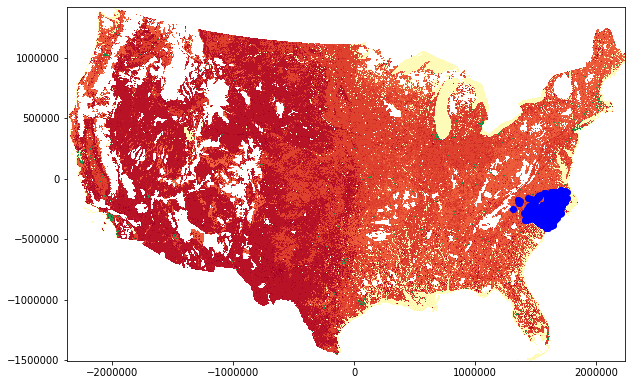

In [25]:
#Plot
fig,ax = plt.subplots(1,1,figsize=(10,10))
plot.show(cost_surface_dataset,ax=ax,cmap='RdYlGn')
gdfBG.plot(ax=ax,color='blue')

In [ ]:
#Iterate through all biogas site rows and create a cost distance raster
cost_arrays = [] #Cost arrays
cd_arrays = []   #Cost distance arrays, min cost distance back to source
tb_arrays = []   #Traceback arrays, for creating the least cost path

for i,r in gdfBG.iterrows():
    xOffset = r['xOffset']    #get the array x coordinate of the biogas source
    yOffset = r['yOffset']    #get the array y coordinate of the biogas soruce
    z = r['Pipe Cost ($/mi-MMBtu@15y)'] / 1609.34   #Get the pipeline cost (5th col) & convert from $/mile to $/meter
    base_cost = 0          #Get the base production cost (4th col)
    
    #Create the minimum cost path (MCP) surface, setting the distance between pixels to cell sizes
    lc_graph = graph.MCP_Geometric(arrCost * z , sampling=(x_size,y_size))
    #Compute cost distances away from the biogas source coordinates
    cd_array,tb_array = lc_graph.find_costs(starts=([(yOffset, xOffset)]))
    #Add the initial cost to all cells
    cd_array = cd_array + base_cost
    #Add to stack of arrays
    cost_arrays.append(arrCost * z)
    cd_arrays.append(cd_array)
    tb_arrays.append(tb_array)
        
#Create a stack of all arrays
arrCostStack = np.stack(cost_arrays)
arrCostDistanceStack =np.stack(cd_arrays)
arrTracebackStack = np.stack(tb_arrays)

#Save the array stacks to file
np.save('../data/DuplinCostStack.npy',arrCostStack)
np.save('../data/DuplinStack.npy',arrCostDistanceStack)
np.save('../data/DuplinTraceStack.npy',arrTracebackStack)